# Final Project: Cartoonize images

Sélim JOMAA & Eve JOUNI

The goal of this project is to build a GAN model capable of cartoonifying images in a Pix2Pix manner. This approach requires a dataset containing pairs of real and cartoonized images. To achieve this, we need to preprocess the dataset by cartoonizing every image and creating a new dataset consisting of these paired images.
But first, let's choose a dataset :

We selected the Faces Dataset (Small) from Kaggle: https://www.kaggle.com/datasets/tommykamaz/faces-dataset-small.

This dataset is a small version of Flickr-Faces-HQ which is an image dataset containing 30,000 high-quality images of human faces. It is provided by NVIDIA under the Creative Commons BY-NC-SA 4.0 license. 

This small dataset contains 5,000 images of various individuals, representing human faces across a wide range of characteristics and expressions. The images capture diverse aspects of people, such as differences in age, gender, ethnicity, and facial expressions, as well as variations in lighting, angles, and moments the pictures were taken, which can be very interesting to play with and study.


**To begin, we chose to use the code provided in the assignment, available through the following repository: https://github.com/Shaashwat05/Cartoonify_reality.**

This repository offers an effective method for cartoonizing images. Our initial goal was to understand how the cartoonization process works and identify the key parameters that can significantly influence the output. This understanding is crucial for ensuring the generated dataset is well-suited for training the GAN model.







# I. Dataset Creation

## 1. Cartoonization with cv2

### 1.1 Imports

First, we start by importing the different libraries that we will need to build the code :

*   os :  handles file paths and directory operations
*   cv2 : read, transform and manipulate the images
*   numpy : manipulate the image's data by clustering
*   scipy : analytical analysis
*   collections : to manage the pixels
*   matplotlib : to visualize our images and compare our results






In [1]:
import os  
import cv2
import pandas
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict

### 1.2 Functions

The update_c function :

*   Each intentisity, which is here the pixels color value, is compared to the center of the clusters and assigned to the closer one.
*   The centers are updated by doing the mean of the different intensity assigned to this cluster, until it treat all the intensity.
*  Once it's done, it reduce the number of course by regrouping the similar intensity into smaller clusters.

**Here the main goal is to achieve a more "cartoon" style by regrouping colors to make it less detailled and more uniform.**



In [2]:
def update_c(C, hist):
    while True:
        groups = defaultdict(list)

        for i in range(len(hist)):
            if hist[i] == 0:
                continue
            d = np.abs(C - i)
            index = np.argmin(d)
            groups[index].append(i)

        new_C = np.array(C)
        for i, indices in groups.items():
            if np.sum(hist[indices]) == 0:
                continue
            new_C[i] = int(np.sum(indices * hist[indices]) / np.sum(hist[indices]))

        if np.sum(new_C - C) == 0:
            break
        C = new_C

    return C, groups

The K_histogram function :


*   The function take an initial center, here equal to 128 and a hist distribution.
*   It use the previous function to update the cluster centers.
*   The smallest clusters are not modified.
*   The biggest clusters are tested to see if they are normalized. If they are not, they will be split in two.

**The main goal is to optimize and refine the color clusters to simplify the color palette, to amplify the "cartoon" effect**

In [3]:
def K_histogram(hist, initial_C=128, alpha=0.001, N=80):
    C = np.array([initial_C])

    while True:
        C, groups = update_c(C, hist)

        new_C = set()
        for i, indices in groups.items():
            if len(indices) < N:
                new_C.add(C[i])
                continue

            z, pval = stats.normaltest(hist[indices])
            if pval < alpha:
                left = 0 if i == 0 else C[i - 1]
                right = len(hist) - 1 if i == len(C) - 1 else C[i + 1]
                delta = right - left
                if delta >= 3:
                    c1 = (C[i] + left) / 2
                    c2 = (C[i] + right) / 2
                    new_C.add(c1)
                    new_C.add(c2)
                else:
                    new_C.add(C[i])
            else:
                new_C.add(C[i])
        if len(new_C) == len(C):
            break
        else:
            C = np.array(sorted(new_C))
    return C

The cartoonize function :


*  We initalize the kernel that will be used later to adjust the contour, and the input image and its size.
*  A bilateral filter is applied for each R, G, B canals to reduce the noises while keeping the contours and smoothing the image.
*  The cv2.canny will detect the contour and generate an image that will be used to add the contour on the cartoonized image.
*  The RGB is converted to HSV, that will be calculated with the histogram to extract the distribution of colors.
* the K_histogram will, for each canals of the HSV, reduce the number of colors by optimizing the center of the colors and regrouping the similar ones.
* The image is rebuilt in 1D for each canals, then in 3D and converted in RGB again.
* The contour previously detected will be drawn and adapted.
* Finally, the function adds a blur to make the images more cartoon-like.

**The main goal is to set up the parameters that will transform the initial image into a cartoon style image.**


In [4]:
def cartoonize(img, config):
    kernel = np.ones(config['erosion_kernel_size'], np.uint8)
    output = np.array(img)
    x, y, c = output.shape

    for i in range(c):
        output[:, :, i] = cv2.bilateralFilter(output[:, :, i],
                                              config['bilateral_filter_d'],
                                              config['sigmaColor'],
                                              config['sigmaSpace'])

    edge = cv2.Canny(output, config['canny_threshold1'], config['canny_threshold2'])

    output = cv2.cvtColor(output, cv2.COLOR_RGB2HSV)
    hists = []
    hist, _ = np.histogram(output[:, :, 0], bins=np.arange(180 + 1))
    hists.append(hist)
    hist, _ = np.histogram(output[:, :, 1], bins=np.arange(256 + 1))
    hists.append(hist)
    hist, _ = np.histogram(output[:, :, 2], bins=np.arange(256 + 1))
    hists.append(hist)

    C = []
    for h in hists:
        C.append(K_histogram(h, initial_C=config['initial_C']))

    output = output.reshape((-1, c))
    for i in range(c):
        channel = output[:, i]
        index = np.argmin(np.abs(channel[:, np.newaxis] - C[i]), axis=1)
        output[:, i] = C[i][index]
    output = output.reshape((x, y, c))
    output = cv2.cvtColor(output, cv2.COLOR_HSV2RGB)

    contours, _ = cv2.findContours(edge, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cv2.drawContours(output, contours, -1, 0, thickness=config['contour_thickness'])

    for i in range(3):
        output[:, :, i] = cv2.erode(output[:, :, i], kernel, iterations=config['erosion_iterations'])

    if config['apply_blur']:
        output = cv2.GaussianBlur(output, config['blur_kernel'], 0)

    return output

### 1.3 Parameters 

The base_config dictionary contains the parameters for the cartoonize function, initially set to the default values provided in the GitHub code. These parameters define how the cartoonization process is applied, influencing various aspects such as edge detection, smoothing, and contour refinement.


***'bilateral_filter_d'*** : Size of the neighborhood for the bilateral filter, controlling the amount of smoothing while preserving edges. Here at 5.

***'sigmaColor'***: For color space, control sensitivity to color variation in the neighborhood, here at 400.

***'sigmaSpace'***: For spatial space, control sensitivity to the distance between neighboring pixels, here at 400.

***'canny_threshold1'***: Lower threshold for edge detection using the canny algorithm. Here at 100.

***'canny_threshold2'***: Upper threshold for edge detection using the canny algorithm, here at 200.

***'initial_C'***: Initial value for color segmentation use by K_histogram, here at 120.

***'erosion_kernel_size'***: Size of the kernel used for erosion, adjusting the strength of the contour refinement effect, hare at (2, 2).

***'erosion_iterations'***: Number of iterations for erosion, determining the strength of contour refinement, here at 1.

***'contour_thickness'***: Thickness of the contours drawn around the areas detected by Canny, here at 1.

***'apply_blur'***: Boolean to enable or disable Gaussian blur on the final image, here at True.

***'blur_kernel'***: Size of the kernel for Gaussian blur, controlling the amount of blur applied to the image, here at (11, 11).






In [5]:
base_config = {
    'bilateral_filter_d': 5,
    'sigmaColor': 400,
    'sigmaSpace': 400,
    'canny_threshold1': 100,
    'canny_threshold2': 200,
    'initial_C': 120,
    'erosion_kernel_size': (2, 2),
    'erosion_iterations': 1,
    'contour_thickness': 1,
    'apply_blur': True,
    'blur_kernel': (11, 11)
}

The project includes a small notebook that demonstrates the impact of changing the parameters on the cartoonization process. This is a valuable resource, as it shows how adjusting the parameters can significantly enhance the quality of the cartoonized images.  

Now that the function and its parameters have been fine-tuned, we are ready to begin processing the dataset images.

## 2. Dataset creation 


### 2.1 Data Processing

The project was executed on a Kaggle notebook, as it provided access to the necessary computational resources. Therefore, the file paths are currently configured for Kaggle but can be easily adjusted for a local setup if needed.

In [ ]:
input_folder = '/kaggle/input/faces-dataset-small/faces_dataset_small'  # Path to input images
save_dir = '/kaggle/working/output_dataset'   #Path to new dataset

if not os.path.exists(save_dir):
    os.makedirs(save_dir)

The goal here is to cartoonize the images in our dataset and save them alongside their original counterparts (real + cartoonized) as pairs. The process involves the following steps:

- **Initialize and Sort Image Paths**:  
  The paths to the images in the dataset are stored in a list. These paths are then sorted numerically based on their unique file names (IDs). Sorting ensures consistency when processing and saving the images as pairs.

- **Process Each Image**:  
  Using the `cv2` library, each image is read one by one. The images are converted from BGR to RGB format for processing. The previously developed **cartoonize** function is applied to each image, using the defined parameter configuration from the `base_config` dictionary.

- **Save the Results**:  
  The cartoonized image is converted back to BGR format to ensure compatibility with most image-saving tools. Both the original and cartoonized images are saved in the designated output path, maintaining their pairing structure.

In [7]:
# Process and save images as pairs (real vs. cartoonized)
images = [f for f in os.listdir(input_folder) if os.path.isfile(os.path.join(input_folder, f))]
images.sort(key=lambda x: int(x.split('.')[0]))  # Sort by numeric value in filename

# Process and save images as pairs (real vs. cartoonized)
for img_name in images:
    img_path = os.path.join(input_folder, img_name)
    if os.path.isfile(img_path):
        original = cv2.imread(img_path)
        original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)
        
        # Apply cartoonize transformation
        cartoon = cartoonize(original, base_config)

        # Save the original and cartoonized images
        real_path = os.path.join(save_dir, f"real_{os.path.basename(img_path)}")
        cartoon_path = os.path.join(save_dir, f"cartoon_{os.path.basename(img_path)}")

        cv2.imwrite(real_path, cv2.cvtColor(original, cv2.COLOR_RGB2BGR))  # Save original
        cv2.imwrite(cartoon_path, cv2.cvtColor(cartoon, cv2.COLOR_RGB2BGR))  # Save cartoonized
        print(f"Saved: {real_path} and {cartoon_path}")

Saved: /kaggle/working/output_dataset/real_00055.png and /kaggle/working/output_dataset/cartoon_00055.png
Saved: /kaggle/working/output_dataset/real_00237.png and /kaggle/working/output_dataset/cartoon_00237.png
Saved: /kaggle/working/output_dataset/real_00240.png and /kaggle/working/output_dataset/cartoon_00240.png
Saved: /kaggle/working/output_dataset/real_00241.png and /kaggle/working/output_dataset/cartoon_00241.png
Saved: /kaggle/working/output_dataset/real_00242.png and /kaggle/working/output_dataset/cartoon_00242.png
Saved: /kaggle/working/output_dataset/real_00243.png and /kaggle/working/output_dataset/cartoon_00243.png
Saved: /kaggle/working/output_dataset/real_00244.png and /kaggle/working/output_dataset/cartoon_00244.png
Saved: /kaggle/working/output_dataset/real_00245.png and /kaggle/working/output_dataset/cartoon_00245.png
Saved: /kaggle/working/output_dataset/real_00246.png and /kaggle/working/output_dataset/cartoon_00246.png
Saved: /kaggle/working/output_dataset/real_002

### 2.2 Dataset Spliting



The goal is to create a dataset split for training and testing while ensuring that the image pairs remain together.

- Separate the Images: After listing all the saved images, we separate the original images and the cartoonized images into two different variables.
- Combine into Pairs: Combine the original and cartoonized images into a list of pairs, assuming each pair corresponds to the same original image and its cartoonized version.

- Split into Train and Test Samples: Split the dataset into training and testing samples.The training set consists of 2,514 images, and the test set contains 629 images.

In [8]:
# Create dataset splits (train/test)
images = [f for f in os.listdir(save_dir) if os.path.isfile(os.path.join(save_dir, f))]
real_images = [img for img in images if "real_" in img]
cartoon_images = [img for img in images if "cartoon_" in img]

# Ensure paired images
paired_images = list(zip(real_images, cartoon_images))
train, test = train_test_split(paired_images, test_size=0.2, random_state=42)

# Display the number of train/test samples
print(f"Train samples: {len(train)}")
print(f"Test samples: {len(test)}")


Train samples: 2514
Test samples: 629


### 2.3 Dataset Splits Saving 

We save the training and testing datasets splits into text files for later use :After defining path for saving, we write into our files the list of the paired items for our train and test dataset.


In [9]:
# Save dataset splits (train/test) to text files
train_data_path = '/kaggle/working/train_pairs.txt'
test_data_path = '/kaggle/working/test_pairs.txt'

with open("train_pairs.txt", "w") as train_file:
    for real, cartoon in train:
        train_file.write(f"{real},{cartoon}\n")

with open("test_pairs.txt", "w") as test_file:
    for real, cartoon in test:
        test_file.write(f"{real},{cartoon}\n")

print("Dataset split saved: train_pairs.txt, test_pairs.txt")


Dataset split saved: train_pairs.txt, test_pairs.txt


### 2.4 Displaying Images

Finally we display pairs of images to ensure that the dataset is well put together :

- We create the `real_images` function that takes a real and cartoon image as arguments and displays them.
- A grid of subplots is created to visualize the image pairs.
- We loop through each pair in the dataset:
  - Load the real and cartoon images using `cv2`.
  - Convert the images from BGR to RGB format for correct color representation in `matplotlib`.
  - Display the images in the subplot grid.

- After displaying the images, we generate a list of processed images in our dataset by identifying the real and cartoon images.
- We prepare the first batch of images, consisting of the first 4 real images and their corresponding cartoon pairs, and display them.


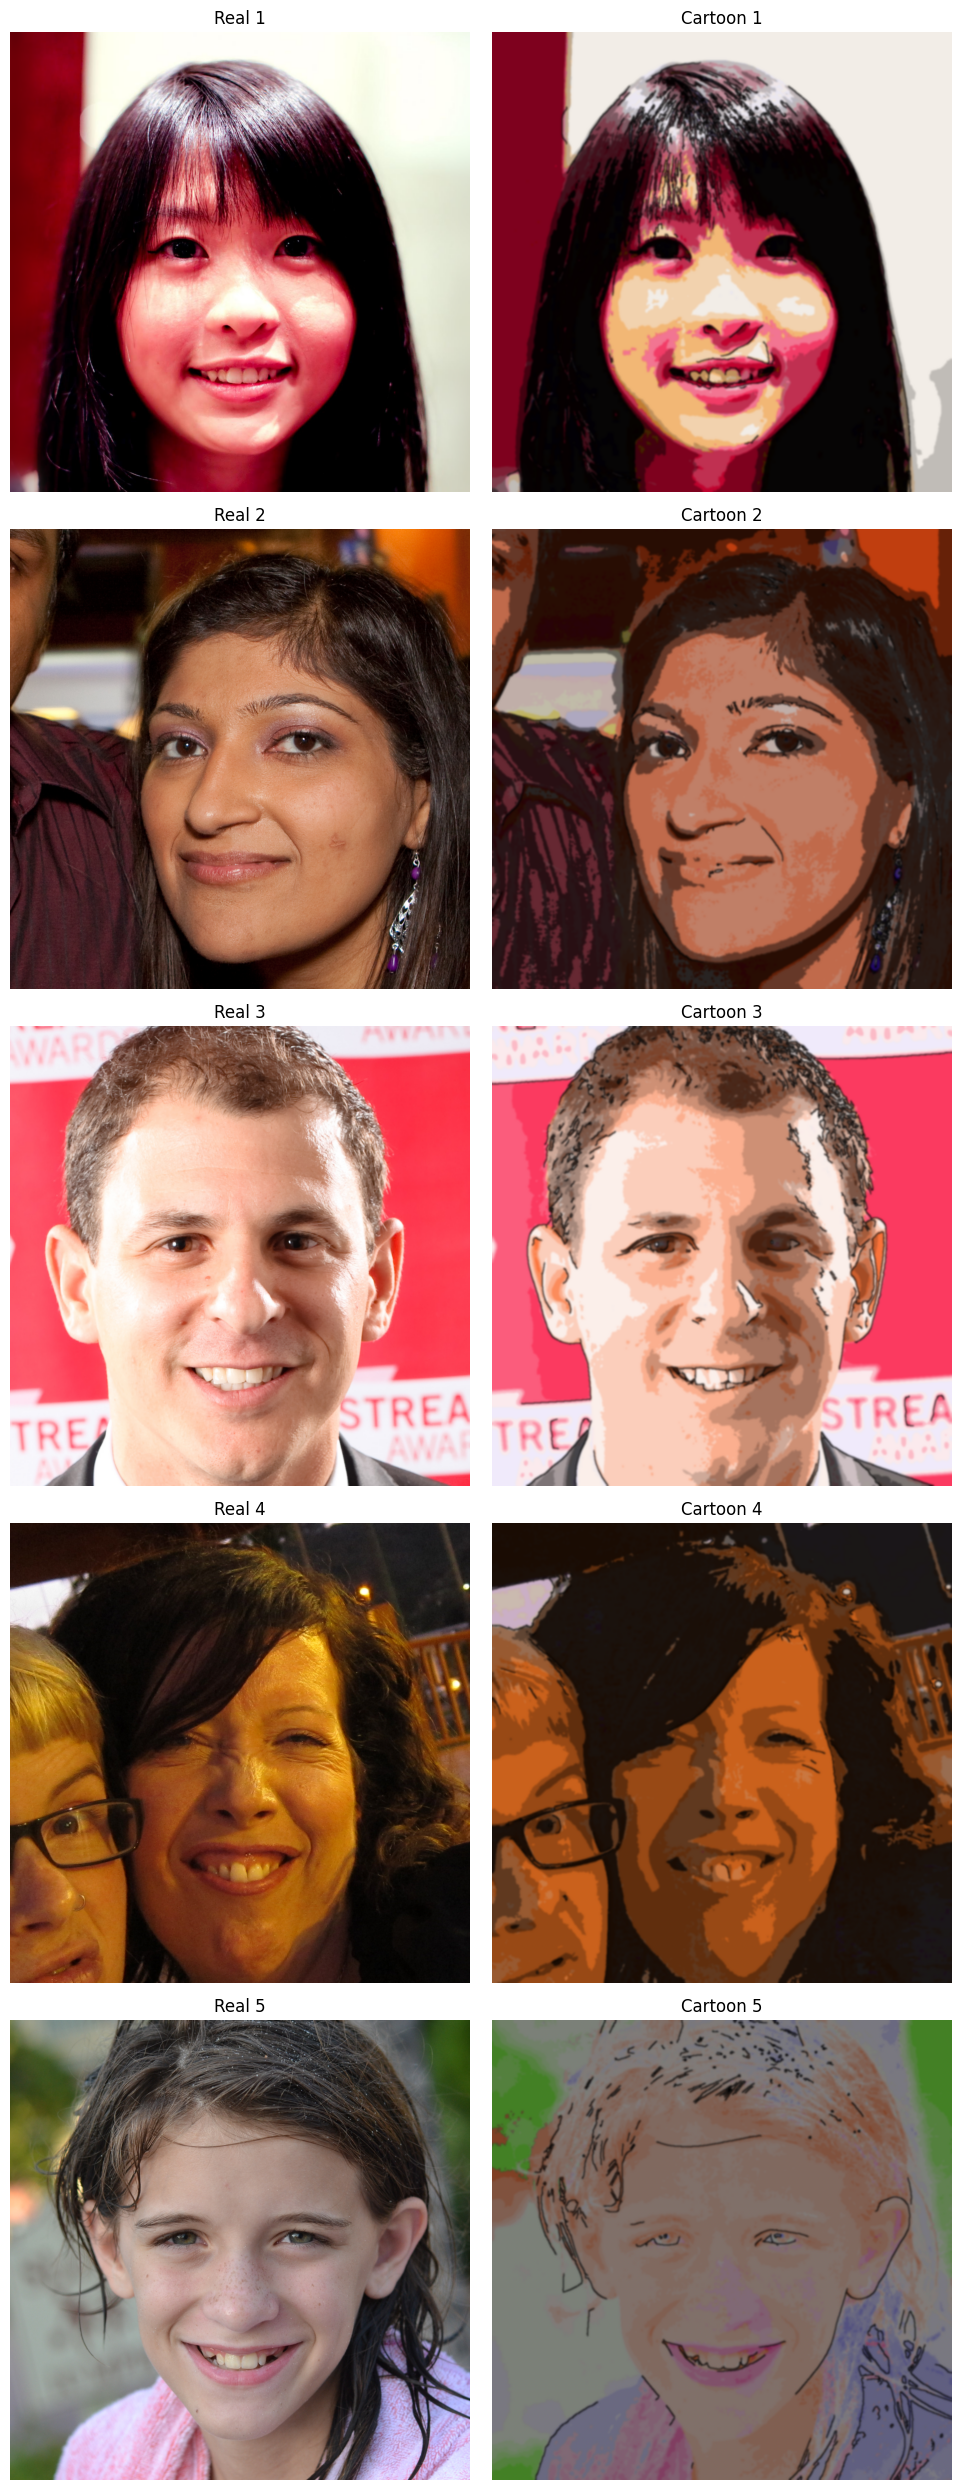

In [10]:
# Function to display a list of image pairs
def display_images_batch(real_images, cartoon_images):
    fig, axes = plt.subplots(len(real_images), 2, figsize=(10, len(real_images) * 5))
    for i in range(len(real_images)):
        # Read the images
        real_img = cv2.imread(real_images[i])
        cartoon_img = cv2.imread(cartoon_images[i])

        # Check if the images are loaded successfully
        if real_img is None:
            print(f"Failed to load real image {real_images[i]}")
            continue
        if cartoon_img is None:
            print(f"Failed to load cartoon image {cartoon_images[i]}")
            continue

        # Convert from BGR to RGB for display
        real_img_rgb = cv2.cvtColor(real_img, cv2.COLOR_BGR2RGB)
        cartoon_img_rgb = cv2.cvtColor(cartoon_img, cv2.COLOR_BGR2RGB)

        # Display original and cartoonized
        axes[i, 0].imshow(real_img_rgb)
        axes[i, 0].set_title(f'Real {i + 1}')
        axes[i, 0].axis('off')

        axes[i, 1].imshow(cartoon_img_rgb)
        axes[i, 1].set_title(f'Cartoon {i + 1}')
        axes[i, 1].axis('off')

    plt.tight_layout()
    plt.show()

# Get the list of processed images (real and cartoonized)
real_images = [f for f in os.listdir(save_dir) if "real_" in f]
cartoon_images = [f for f in os.listdir(save_dir) if "cartoon_" in f]

# Sort the images by their numbers to ensure they align
real_images_sorted = sorted(real_images, key=lambda x: int(x.split('_')[1].split('.')[0]))
cartoon_images_sorted = sorted(cartoon_images, key=lambda x: int(x.split('_')[1].split('.')[0]))

# Construct the full paths for the first 5 pairs of images
first_real_images = [os.path.join(save_dir, img) for img in real_images_sorted[:5]]
first_cartoon_images = [os.path.join(save_dir, img) for img in cartoon_images_sorted[:5]]

# Display the first five image pairs
display_images_batch(first_real_images, first_cartoon_images)

We can see that the images are well "cartoonized" with the cartoonize function that we have built, and the data is ready to be learned by our model ! 

# II. Training a cGAN

## 1. cGAN Components

### 1.1 Imports

We start by importing all the libraries needed :

- **os**: For handling file paths and directory operations.
- **time**: To measure the time taken for operations.
- **torch**: Core library for the PyTorch framework.
- **scipy.stats**: For statistical operations (e.g., data analysis).
- **sklearn.model_selection.train_test_split**: For splitting data into training and testing sets.
- **torchvision.transforms**: For applying image transformations.
- **torch.utils.data.Dataset, DataLoader**: For creating custom datasets and loading them in batches.
- **PIL.Image**: For handling image file formats.
- **torchvision.models.vgg16**: Pretrained VGG16 model for feature extraction.

In [ ]:
import time 
import torch 
from scipy import stats 
from sklearn.model_selection import train_test_split 
from torchvision import transforms 
from torch.utils.data import Dataset, DataLoader 
from PIL import Image s
from torchvision.models import vgg16 

### 1.2 Parameters  

We then initialize the parameters that we will use in our architecture :

- **Image size**: Set to 128 after dimensioning. This size is chosen as an average, providing a good balance for optimizing calculations.
- **Batch size**: Set to 64, used for batching the images during training to optimize memory usage and computation.
- **Latent vector size**: Set to 100, which encodes image characteristics in a compact space.
- **Learning rate**: Set to 1e-4, determining the step size for updating the model's weights during training.
- **Number of epochs**: Set to 100, indicating the number of times the entire training dataset will be processed during the learning phase.


In [31]:
data_folder = '/kaggle/working/output_dataset'
img_size = 128  # Image size
batch_size = 64  # Batch size
z_size = 100  # Latent vector size
lr_generator = 0.0001  # Learning rate for generator
lr_discriminator = 0.0004  # Learning rate for discriminator
epochs = 100  # Number of epochs

### 1.3 Classes

**CartoonDataset class**

- It reads the file line by line, extracting the paths of real and cartoon images.
- The images are opened, transformations are applied, and they are stored in `self.real_images` and `self.cartoon_images`.
- It automatically loads and pairs images from the provided file.

The goal of this class is to handle paired images, facilitating the loading, transforming, and retrieval of these image pairs for model training and evaluation.


In [33]:
# Dataset class
class CartoonDataset(Dataset):
    def __init__(self, pairs_file, base_folder, transform):
        self.transform = transform
        self.real_images = []
        self.cartoon_images = []
        
        with open(pairs_file, 'r') as f:
            for line in f:
                real_img_name, cartoon_img_name = line.strip().split(',')
                real_img_path = os.path.join(base_folder, real_img_name)
                cartoon_img_path = os.path.join(base_folder, cartoon_img_name)

                real_img = Image.open(real_img_path).convert("RGB")
                cartoon_img = Image.open(cartoon_img_path).convert("RGB")

                self.real_images.append(transform(real_img))
                self.cartoon_images.append(transform(cartoon_img))

    def __len__(self):
        return len(self.real_images)

    def __getitem__(self, idx):
        return self.real_images[idx], self.cartoon_images[idx]


**Generator class**

- **nn.Conv2d**:  Extracts spatial features and downsamples the input, learning hierarchical representations of the data.

- **nn.ReLU**:  Introduces non-linearity, allowing the network to learn complex transformations and make the model capable of approximating any function.

- **nn.BatchNorm2d**:  Stabilizes training by normalizing the activations in the network, speeding up convergence and improving generalization.

- **nn.ConvTranspose2d**:   Upsamples the feature maps to reconstruct higher-resolution images from the lower-dimensional features.

- **nn.Tanh**:   Ensures the output values are scaled to the range [-1, 1], which is suitable for normalized image data, often used for generative models.


The goal is to define the Generator class, a neural network designed to generate images. It takes an input image and outputs a new, generated image.



In [ ]:
#Generator
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1),
            nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

**Discriminator Class**

- **nn.Conv2d**:  
  Extracts spatial features from the input image and downsamples it, learning important features of the image.

- **nn.LeakyReLU(0.2)**:  
  Introduces non-linearity and allows a small gradient to pass when the input is negative. The parameter 0.2 specifies the negative slope for the activation, preventing the "dying ReLU" problem.

- **nn.BatchNorm2d**:  
  Stabilizes the learning process and helps the network converge faster by normalizing the activations within each batch.

- **nn.Flatten**:  
  Converts the multi-dimensional output from the last convolutional layer into a 1D vector, which is required for the fully connected layer to process.

- **nn.Linear**:  
  Maps the flattened output to a scalar value, representing the discriminator’s confidence that the input image is real (as opposed to fake).

- **nn.Sigmoid**:  
  Squashes the output between 0 and 1, representing the probability that the input image is real (1) or fake (0).

- **Forward Method**:  
  Defines how the input data flows through the network during a forward pass, applying all layers in sequence.

The goal is to define the Discriminator class, which classifies images as real or fake (cartoonized), helping the GAN distinguish between generated and actual images.


In [35]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.Conv2d(128, 256, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Flatten(),
            nn.Linear(256 * (img_size // 8) * (img_size // 8), 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

### 1.4 Models Initialization 



In [17]:
# Initialize Models
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

torch.cuda.get_device_name(0)


Using device: cuda


'Tesla T4'

**GPU usage**

Throughout the project, we had access to a **T4 GPU**, which was extremely beneficial as it provided significantly more computational power than initially expected. We utilized the GPU for a total of **22 hours**, which greatly accelerated the training and testing processes.







We initialize our Generator and Discrimintor models based on the device available, in this case the GPU.

In [36]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

### 1.5 Loss Functions and Optimizers

To train the model effectively, we define the necessary **loss functions** and **optimizers** that guide the training process:

- **Loss Functions**:
  - `adversarial_loss`: Binary Cross-Entropy loss for distinguishing real and fake images.
  - `l1_loss`: L1 loss for ensuring consistency between the generated and real images.

- **Optimizers**:
  - `g_optimizer`: Adam optimizer for the Generator with specific learning rates and betas. The values `(0.5, 0.999)` for the betas are chosen to help stabilize training, particularly in the early stages, by giving more weight to recent gradients and smoothing out the optimization process.
  - `d_optimizer`: Adam optimizer for the Discriminator with specific learning rates and betas. Similar to the Generator, the betas `(0.5, 0.999)` are used to improve convergence and prevent instability during training.


In [38]:
# Loss functions
adversarial_loss = nn.BCELoss()
l1_loss = nn.L1Loss()

# Optimizers
g_optimizer = optim.Adam(generator.parameters(), lr=lr_generator, betas=(0.5, 0.999))
d_optimizer = optim.Adam(discriminator.parameters(), lr=lr_discriminator, betas=(0.5, 0.999))

**VGG16**

Now, we define a custom loss function called PerceptualLoss, which uses the VGG16 model's feature extractor to compute the perceptual similarity between the predicted and target images. 
It allows the model to optimize based on the semantic content of the images rather than pixel-by-pixel accuracy, improving the quality of generated images by aligning their content at a higher level of abstraction.

In [40]:
class PerceptualLoss(nn.Module):
    def __init__(self, feature_layer=10):
        super(PerceptualLoss, self).__init__()
        vgg = vgg16(pretrained=True).features
        self.features = nn.Sequential(*list(vgg[:feature_layer])).eval()
        for param in self.features.parameters():
            param.requires_grad = False

    def forward(self, pred, target):
        pred_features = self.features(pred)
        target_features = self.features(target)
        loss = nn.functional.mse_loss(pred_features, target_features)
        return loss

 **DiscminatorLoss**


The custom loss function for the **discriminator** computes the loss based on its ability to distinguish between real and fake images:

- **BCELoss()**: Measures how well the discriminator predicts real or fake labels, which is crucial for training the discriminator.

The function returns three values:
  - `total_loss`: Used for updating the discriminator's weights, representing the overall loss for both real and fake images.
  - `fake_loss`: The loss associated with fake images, helping to assess how well the discriminator distinguishes fake images from real ones.
  - `real_loss`: The loss associated with real images, helping to assess how well the discriminator identifies real images.


In [41]:
class DiscriminatorLoss(nn.Module):
    def __init__(self):
        super(DiscriminatorLoss, self).__init__()
        self.adversarial_loss = nn.BCELoss()

    def forward(self, pred_fake, pred_real):
        fake_loss = self.adversarial_loss(pred_fake, torch.zeros_like(pred_fake))
        real_loss = self.adversarial_loss(pred_real, torch.ones_like(pred_real))
        total_loss = (fake_loss + real_loss) / 2
        return total_loss, fake_loss, real_loss


### 1.6 Image Transformation
In order to standardize and prepare the images for model training, we apply the following transformations:

- **Resize**: The images are resized to a fixed size of 128x128 pixels.
- **Convert to Tensor**: `transforms.ToTensor()` is used to convert the images from their original format to a PyTorch tensor, which is required for model training.
- **Normalize**: The pixel values are scaled to the range [-1, 1] to ensure the model processes the data consistently.

In [42]:
#Image transformation 

transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),      # Resize to 128x128
    transforms.ToTensor(),                        # Convert to PyTorch tensor
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])  # Normalize to [-1, 1]
])

## 2. cGan Training



It's now time to implement the training loop for both the generator and discriminator. Here’s how it works:

- **Discriminator Training**: The discriminator learns to distinguish between real and fake images (real images are labeled as 1, fake images as 0).
  
- **Generator Training**: The generator learns to produce images that the discriminator classifies as real, while also minimizing the pixel-wise difference between generated images and the target (cartoon images).

- **Loss Backpropagation**: The losses are backpropagated, and the optimizers adjust the model parameters to minimize these losses, improving the generator and discriminator over time.

This process repeats itself for each epoch until the models converge or achieve good performance.

Here, we creates data loaders for training and testing by automating data feeding into the model during training and evaluation.

In [43]:
# Data loaders
train_dataset = CartoonDataset(train_data_path, data_folder, transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = CartoonDataset(test_data_path, data_folder, transform)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

### 2.1 Models Training

In [44]:
# Initialize Loss Functions
perceptual_loss = PerceptualLoss().to(device)
d_loss_fn = DiscriminatorLoss()

for epoch in range(epochs):
    start_time = time.time()
    epoch_d_loss = 0.0
    epoch_g_loss = 0.0

    for real_imgs, cartoon_imgs in train_loader:
        real_imgs, cartoon_imgs = real_imgs.to(device), cartoon_imgs.to(device)

        # Train Discriminator
        discriminator.zero_grad()
        real_validity = discriminator(cartoon_imgs)
        fake_imgs = generator(real_imgs)
        fake_validity = discriminator(fake_imgs.detach())

        # Use DiscriminatorLoss class
        d_loss, d_fake_loss, d_real_loss = d_loss_fn(fake_validity, real_validity)
        d_loss.backward()
        d_optimizer.step()

        # Train Generator
        generator.zero_grad()
        fake_validity = discriminator(fake_imgs)
        
        # Calculate adversarial, L1, and perceptual losses
        g_adv_loss = adversarial_loss(fake_validity, torch.ones_like(fake_validity, device=device))
        g_l1_loss = l1_loss(fake_imgs, cartoon_imgs)
        g_perceptual_loss = perceptual_loss(fake_imgs, cartoon_imgs)
        
        # Total generator loss
        g_loss = g_adv_loss + g_l1_loss + g_perceptual_loss
        g_loss.backward()
        g_optimizer.step()

        epoch_d_loss += d_loss.item()
        epoch_g_loss += g_loss.item()

    epoch_d_loss /= len(train_loader)
    epoch_g_loss /= len(train_loader)
    
    epoch_time = time.time() - start_time
    print(f"Epoch {epoch + 1}/{epochs} | Discriminator Loss: {epoch_d_loss:.4f} | Generator Loss: {epoch_g_loss:.4f} | Time: {epoch_time:.2f}s")


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 154MB/s]  


Epoch 1/100 | Discriminator Loss: 0.2313 | Generator Loss: 17.7940 | Time: 17.89s
Epoch 2/100 | Discriminator Loss: 0.5995 | Generator Loss: 17.3216 | Time: 18.91s
Epoch 3/100 | Discriminator Loss: 0.9005 | Generator Loss: 13.0187 | Time: 17.84s
Epoch 4/100 | Discriminator Loss: 0.7660 | Generator Loss: 11.5120 | Time: 17.09s
Epoch 5/100 | Discriminator Loss: 0.6413 | Generator Loss: 11.4243 | Time: 17.10s
Epoch 6/100 | Discriminator Loss: 0.6687 | Generator Loss: 11.5630 | Time: 17.57s
Epoch 7/100 | Discriminator Loss: 0.5682 | Generator Loss: 11.1508 | Time: 17.91s
Epoch 8/100 | Discriminator Loss: 0.5689 | Generator Loss: 11.6667 | Time: 17.71s
Epoch 9/100 | Discriminator Loss: 0.4727 | Generator Loss: 12.0524 | Time: 17.50s
Epoch 10/100 | Discriminator Loss: 0.4536 | Generator Loss: 12.3553 | Time: 17.42s
Epoch 11/100 | Discriminator Loss: 0.4201 | Generator Loss: 12.7226 | Time: 17.54s
Epoch 12/100 | Discriminator Loss: 0.5193 | Generator Loss: 12.4200 | Time: 17.64s
Epoch 13/100 

### Interpretation of the Training Results:

1. **The Discriminator Loss**: 

*It tries to classify whether the images are real or fake, with the goal of minimizing the loss. It measures how well it is doing at this task.*

Here, the discriminator loss bounces around a lot, but overall, it's going down.

2. **The Generator Loss**: 

*It is trying to make fake images that look like real ones. The Generator Loss shows how bad the generator is at tricking the discriminator.*

In our case, the Generator Loss is high at the beginning but goes down slowly over time, meaning that it is learning.

#### **General Observation**:

- At the start, the discriminator is doing okay (loss of 0.2313), but the generator is struggling (loss of 17.79).

- As training goes on, the Discriminator Loss stays low with a few spikes, and the Generator Loss decreases, showing that the generator is getting better.

- By the end, the Discriminator Loss is low (0.1329), and the Generator Loss is also lower (11.9984), which means both networks are getting better at their tasks and are more balanced.

- Each epoch takes around 17.5 to 18 seconds, which is a good sign that the training time per epoch is stable.





### 2.2 Models Saving

In [45]:
generator_path = '/kaggle/working/generator.pth'
discriminator_path = '/kaggle/working/discriminator.pth'

torch.save(generator.state_dict(), generator_path)
torch.save(discriminator.state_dict(), discriminator_path)

print(f"Models saved: {generator_path}, {discriminator_path}")


Models saved: /kaggle/working/generator.pth, /kaggle/working/discriminator.pth


### 2.3 Generator Model Testing

The function **cartoonify_images** will take an input image, process it using the pre-trained generator, and generate a cartoon version of that same image. 

In [29]:
#Test the model
def cartoonify_image(image_path, generator, transform):
    generator.eval()
    img = Image.open(image_path).convert("RGB")
    img_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        cartoonized = generator(img_tensor).squeeze().cpu()
    return transforms.ToPILImage()(cartoonized)


In [ ]:
image_path = "your_image_path.jpg"
cartoonified_image = cartoonify_image(image_path, generator, transform)

# Display the cartoonified image
cartoonified_image.show()
cartoonified_image.save("cartoonified_image.jpg")

### 2.4 Images Displaying

The **visualize_cartoonified_images** function is designed to:

- Take a batch of real images from the test dataset.
- Use the generator model to create cartoonized versions of these images.
- Display a side-by-side comparison of the original real images and their cartoonified versions.

The function will display a grid of images where the top row contains the original images, and the bottom row contains their cartoonified counterparts.

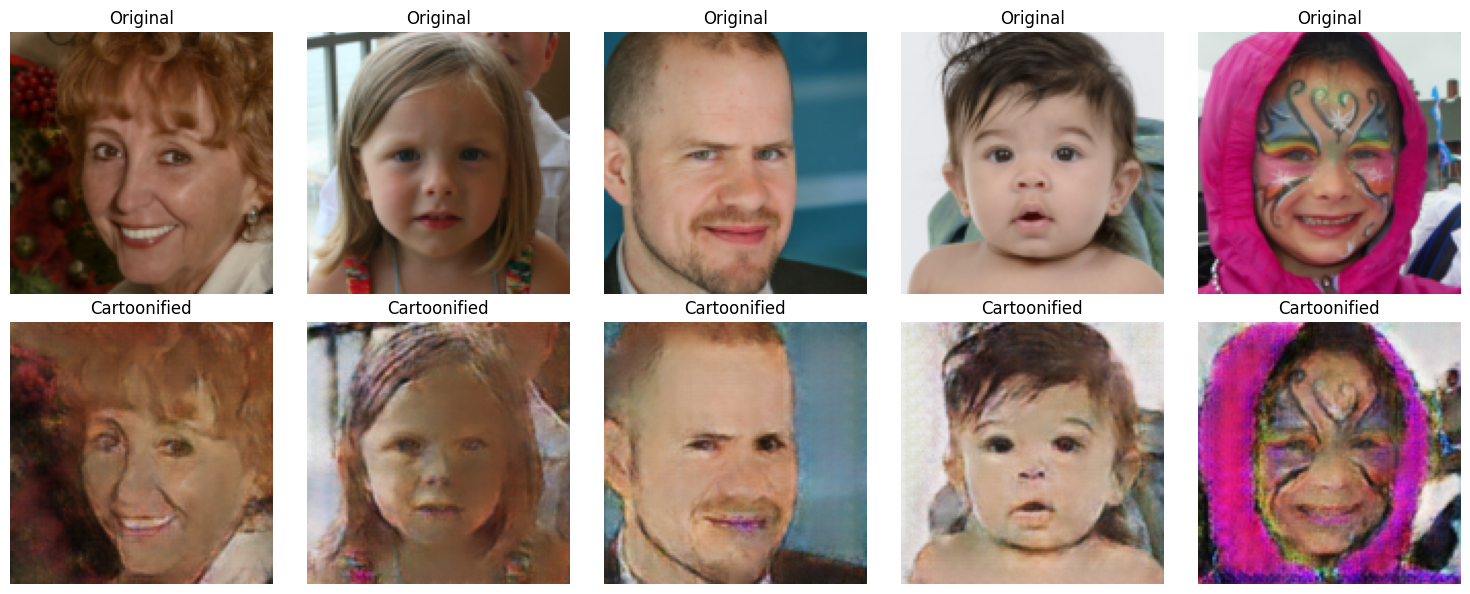

In [46]:
def visualize_cartoonified_images(generator, test_loader, num_images=5, device=device):
    generator.eval()  # Set generator to evaluation mode
    with torch.no_grad():
        # Fetch a batch of real images from the test loader
        for real_images, _ in test_loader:
            real_images = real_images.to(device)
            
            # Generate cartoonified images using the generator
            cartoonified_images = generator(real_images)
            
            # Ensure we don't exceed the number of available images
            num_available_images = min(num_images, real_images.size(0))
            real_images = real_images[:num_available_images].cpu()
            cartoonified_images = cartoonified_images[:num_available_images].cpu()
            
            # Display the original and cartoonified images
            fig, axes = plt.subplots(2, num_available_images, figsize=(15, 6))
            for i in range(num_available_images):
                # Original image
                axes[0, i].imshow((real_images[i].permute(1, 2, 0) + 1) / 2)  # Unnormalize [-1, 1] to [0, 1]
                axes[0, i].axis('off')
                axes[0, i].set_title("Original")
                
                # Cartoonified image
                axes[1, i].imshow((cartoonified_images[i].permute(1, 2, 0) + 1) / 2)  # Unnormalize [-1, 1] to [0, 1]
                axes[1, i].axis('off')
                axes[1, i].set_title("Cartoonified")
            
            plt.tight_layout()
            plt.show()
            break  # Only process one batch

# Visualize cartoonified images
visualize_cartoonified_images(generator, test_loader, num_images=5, device=device)


# III. Results

## 1. Results

As you can see from the training results, the images appear somewhat cartoonized, but the quality is far from ideal. However, these were not our best results. In fact, the best outcome was achieved with different parameters and fewer epochs. While the results were not perfect, we were still satisfied with what we managed to accomplish. 

Throughout the process, we experimented with a variety of combinations, tweaking the initial learning rate and incorporating a feature that adjusted the learning rate during training if the losses stagnated for more than 10 epochs. We also tested training durations ranging from 15 to 200 epochs, which took a significant amount of time but was necessary to optimize the training as much as possible. Additionally, we experimented with different batch sizes, ranging from 2 to 128. 

Although we tried the Pix2Pix GAN implementation, the results were poor. We also attempted a Wasserstein GAN but did not achieve promising results. Ultimately, the best training configuration came with 50 epochs, a learning rate of 0.0001, and a small batch size of 2. This generator model produced the best cartoonized images.



## 2. Further Work

To present our work effectively, we also developed an interface implementing our best generator model. However, this interface was not deployed and is intended to run locally on a localhost.

Finally, most of the tests we conducted will be available in a test folder in the GitHub repository, even if they are not presented in the best format. The purpose of this folder is to showcase the effort put into this project and to provide resources that could potentially be reused in the future.

## 3. Moving Forward

If we were to continue with this project, we would aim to improve the quality of our GAN by focusing on the Flickr-Faces-HQ dataset, as we believe our results could have been limited by the dataset size. Additionally, we would continue fine-tuning the parameters to achieve the best possible training outcomes.

